In [1]:
import os
import re
import glob
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
from roiList_MVPA import m_name_list, roi_plot_list
from RSA_target_matrices import *

In [3]:
targ_matrices = [fst_pairs, snd_pairs, tpl_nonadj, within_tpl, rare_connect, irrelvant]
targ_namelist = ['fst_pairs','snd_pairs','tpl_nonadj','within_tpl','rare_connect','irrelvant']

targ_matrices = targ_matrices + [tpl_A, tpl_B, tpl_C, tpl_D]
targ_namelist = targ_namelist + ["tpl_A", "tpl_B", "tpl_C", "tpl_D"]

In [4]:
stim_type = ['tpl_orig', 'tpl_sorted', 'shape_png'][2]
stim_list = {
    'tpl_orig': ['A1','A2','A3','B1','B2','B3','C1','C2','C3','D1','D2','D3'],
    'tpl_sorted': ['A-1','A-2','A-3','B-1','B-2','B-3','C-1','C-2','C-3','D-1','D-2','D-3'],
    'shape_png': [ '{:02d}'.format(x) for x in range(1, 13) ]
}[stim_type]

In [6]:
def do_ttests(smc_DF, roi_list, targ1, targ2=None, alt="two-sided"):
    tt_res = { roi: {} for roi in m_name_list }
    for roi in roi_list:
        select_roi = smc_DF.columns.get_level_values("ROI").isin([roi])
        smc_DF_roi = (smc_DF.loc[:, select_roi]
                            .melt(var_name=["ROI", "Targ"], value_name="Avg_SMC"))
        ## ons-sample t-test:
        if targ2 is None:
            tt_res[roi]["t_vals"], tt_res[roi]["p_vals"] = stats.ttest_1samp(
                smc_DF_roi.loc[smc_DF_roi["Targ"] == targ1, :]["Avg_SMC"], 
                popmean=0, alternative=alt)
        ## paired-sample t-test:
        else:
            tt_res[roi]["t_vals"], tt_res[roi]["p_vals"] = stats.ttest_rel(
                smc_DF_roi.loc[smc_DF_roi["Targ"] == targ1, :]["Avg_SMC"],
                smc_DF_roi.loc[smc_DF_roi["Targ"] == targ2, :]["Avg_SMC"],
                alternative=alt)
    return pd.DataFrame(tt_res).T

In [7]:
def plot_my_ttest(ttype, DF_sig, selected_rois, 
                  ax, pos_y, pos_ha="left", pos_va="bottom", txt_color="r"):
    idx_list = [ selected_rois.index(roi) for roi in list(DF_sig.index) ]
    pval_list = list(DF_sig["p_vals"])
    for pos_x, p_val in zip(idx_list, pval_list):
        p_print = "p = {:}".format(round(p_val, 3))
        p_print.replace("0.", ".")
        ## ons-sample t-test:
        if ttype == "1samp":
            ax.text(x=pos_x, y=pos_y, s=p_print,
                    color=txt_color, fontsize=15, style="italic",
                    rotation=90, va=pos_va, ha=pos_ha)
        ## paired-sample t-test:
        if ttype == "2samp":
            ax.hlines(y=pos_y, xmin=pos_x-.2, xmax=pos_x+.2, colors='r', linewidth=3)
            ax.text(x=pos_x, y=pos_y, s=p_print, 
                    color=txt_color, fontsize=20, # style="italic",
                    rotation=45, ha=pos_ha)
    return ax

In [8]:
def plot_my_compares(long_DF, selected_rois, tar_a, tar_b, 
                     DF_1s_a_pSig, DF_1s_b_pSig, DF_1s_a_nSig, DF_1s_b_nSig, DF_pwtt_sig, 
                     fig_title, fp, fig_size=(20, 10), 
                     tar_a_color=tar_a_color, legend_loc='lower left', ylim=None):
    
    fig, ax = plt.subplots(figsize=fig_size, dpi=500)
    sns.set(style='white', font_scale=1.5)
#     sns.violinplot(
#         inner="quart", split=True, gap=.1, bw_adjust=.1, # controls the amount of smoothing
    sns.boxplot(
        data=long_DF, 
        x="ROI", y="Avg_SMC",
        hue="Targ", hue_order=[tar_a, tar_b], 
        palette={tar_a: tar_a_color, tar_b: ".85"}, 
        linewidth=1, color="k"
    )
    ax.set_xticklabels(selected_rois, rotation=90, fontsize=20)
    ax.axhline(0, color="r", linewidth=2, linestyle=":")
    
    ## ons-sample, positive:
    for DF_sig, pos_ha, txt_color in [(DF_1s_a_pSig, "right", "k"), 
                                      (DF_1s_b_pSig, "left", ".85")]:
        if DF_sig is not None and len(DF_sig) > 0: 
            ax = plot_my_ttest("1samp", DF_sig, selected_rois, ax, 
                               pos_y = long_DF["Avg_SMC"].quantile(1), 
                               pos_ha=pos_ha, txt_color=txt_color)
    ## ons-sample, negitive:
    for DF_sig, pos_ha, txt_color in [(DF_1s_a_nSig, "right", "k"), 
                                      (DF_1s_b_nSig, "left", ".85")]:
        if DF_sig is not None and len(DF_sig) > 0: 
            ax = plot_my_ttest("1samp", DF_sig, selected_rois, ax, 
                               pos_y = long_DF["Avg_SMC"].quantile(1) * -1, 
                               pos_ha=pos_ha, pos_va="top", txt_color=txt_color)
    ## paired-sample:
    if len(DF_pwtt_sig) > 0: 
        ax = plot_my_ttest("2samp", DF_pwtt_sig, selected_rois, ax, 
                           pos_y = long_DF['Avg_SMC'].quantile(.85))
    if ylim is not None:
        ax.set_ylim(ylim)  
    ax.set_xlabel(None)
    ax.set_ylabel("similarity changes", size=20)
    ax.tick_params(axis="y", labelsize=20)
    ax.legend(loc=legend_loc) 
    sns.despine(left=True, bottom=True)
    plt.suptitle(fig_title)
    plt.tight_layout()
#     plt.savefig(fp, format="png")
#     plt.close()
#     plt.clf()

In [9]:
def remove_outlier_indices(data, col="Avg_SMC"):
    if type(data) is pd.DataFrame:
        data = data[col]
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    not_outliers = ~ ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))
    return not_outliers

In [10]:
## Quick setup:
afni_desc = 'runs_v5'
reml = ['', '_REML'][0]
lss = ['LSS.', ''][0]
estm = ['Betas{:}'.format(reml), 'Tstats{:}'.format(reml)][0]
meas = ['euclidean', 'correlation'][1]
sub_folder = ["r01_x_r10", "r02_to_r09"][1]

# top_dir = os.path.join("/media", "data1", "pinwei", "SL_hippocampus")
# mvpa_top = os.path.join(top_dir, "Combined_group", "derivatives", "PyMVPA")
# data_top = os.path.join(mvpa_top, "BACKUP_masked_data")
mvpa_top = "PyMVPA"
clf_top = os.path.join(mvpa_top, "classification_out")
rdm_top = os.path.join(mvpa_top, "similarity_matrices")
mats_dir = os.path.join(rdm_top, stim_type, "ap-{:}".format(afni_desc), lss+estm, 
                        "PDist_{:}".format(meas), sub_folder)
print(mats_dir)
print(os.path.exists(mats_dir))

PyMVPA\similarity_matrices\shape_png\ap-runs_v5\LSS.Betas\PDist_correlation\r02_to_r09
True


In [11]:
smc_df_list = []

for roi in m_name_list:
    similarity_change = { targ_name: {} for targ_name in targ_namelist }

    for file_path in glob.glob(os.path.join(mats_dir, '{:}_*.csv'.format(roi))):
        file_name = file_path.split("/")[-1]
        subj = re.findall(r'(sub-[\d]+).csv', file_name)[0]
        full_mat = np.loadtxt(file_path, delimiter=',')
        sub_mats = {
            'pre': full_mat[:12, :12],
            'post': full_mat[-12:, -12:]
        }
        for targ_mat, targ_name in zip(targ_matrices, targ_namelist):
            sm_diff = np.subtract(sub_mats['pre'],   # pre-exposure  "dis-similarity"
                                  sub_mats['post'])  # post-exposure "dis-similarity"
                                                     # --> post > pre "similarity"
            extract_vals = sm_diff * targ_mat
            avg = extract_vals.sum() / targ_mat.sum()
            similarity_change[targ_name][subj] = avg # "similarity" increase

    smc_df = pd.DataFrame(similarity_change)
    smc_df_list.append(smc_df)

smc_DF = pd.concat(smc_df_list, axis = 1, keys=(m_name_list), names=["ROI", "Targ"])
# smc_DF.to_csv(os.path.join(mats_dir, "all_similarity_changes.csv"))

# MDS

In [ ]:
from sklearn.manifold import MDS

In [ ]:
sns.set(style = 'white', 
        rc={"lines.linewidth": 2.5})

In [ ]:
roi = m_name_list[26]
file_list = glob.glob(os.path.join(mats_dir, '{:}_*.csv'.format(roi)))
# file_list = glob.glob(os.path.join(mats_dir, '{:}_sub-127.csv'.format(roi)))

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
for file_path in file_list:
    full_mat = np.loadtxt(file_path, delimiter=',')
    sub_mats = {
        'pre': full_mat[:12, :12],
        'post': full_mat[-12:, -12:]
    }
    for axn, (run, RDM) in enumerate(sub_mats.items()):
        mds = MDS(
            n_components=2, 
            dissimilarity="precomputed", 
            normalized_stress='auto',
            random_state=0
        )
        results = mds.fit(RDM)
        coords_2d = results.embedding_

        # ## triplet-based
        # for id, color in zip(np.arange(0, 12, 3, dtype=int), 
        #                      list(mpl.colors.TABLEAU_COLORS)[:4]):
        #     idxs = np.arange(id, id+3, dtype=int)
        #     axs[axn].scatter(
        #         coords_2d[idxs, 0], coords_2d[idxs, 1], # 2-D
        #         marker='o', s=50, c=color
        #     )

        ## order-based
        for id, color in zip(range(3), list(mpl.colors.TABLEAU_COLORS)[:3]):
            idxs = np.arange(id, 12, 3, dtype=int)
            axs[axn].scatter(
                coords_2d[idxs, 0], coords_2d[idxs, 1], # 2-D
                marker='o', s=50, c=color
            )
        
        # axs[axn].set_title("run-{:}".format(run))
        axs[axn].set_title(run)
        a = 1 # 40
        axs[axn].set_xlim([a, -a])  
        axs[axn].set_ylim([a, -a])  
        sns.despine(left=True, bottom=True)
    
plt.suptitle("2-D multi-dimensional scaling (MDS) plots")
# plt.legend(["A", "B", "C", "D"], bbox_to_anchor=(1,.7), loc="upper left")
plt.legend(["1st", "2nd", "3rd"], bbox_to_anchor=(1,.7), loc="upper left")
plt.tight_layout()

In [ ]:
roi = m_name_list[26]
file_list = glob.glob(os.path.join(mats_dir, '{:}_*.csv'.format(roi)))
# file_list = glob.glob(os.path.join(mats_dir, '{:}_sub-127.csv'.format(roi)))

fig, axs = plt.subplots(1, 2, figsize=(8, 4), 
                        subplot_kw={"projection": "3d"})
for file_path in file_list:
    full_mat = np.loadtxt(file_path, delimiter=',')
    sub_mats = {
        'pre': full_mat[:12, :12],
        'post': full_mat[-12:, -12:]
    }
    for axn, (run, RDM) in enumerate(sub_mats.items()):
        mds = MDS(
            n_components=3, 
            dissimilarity="precomputed", 
            normalized_stress='auto',
            random_state=0
        )
        results = mds.fit(RDM)
        coords_3d = results.embedding_

        # ## triplet-based
        # for id, color in zip(np.arange(0, 12, 3, dtype=int), 
        #                      list(mpl.colors.TABLEAU_COLORS)[:4]):
        #     idxs = np.arange(id, id+3, dtype=int)
        #     axs[axn].scatter(
        #         coords_3d[idxs, 0], coords_3d[idxs, 1], coords_3d[idxs, 2], # 3-D
        #         marker='o', s=50, c=color
        #     )
        
        ## order-based
        for id, color in zip(range(3), list(mpl.colors.TABLEAU_COLORS)[:3]):
            idxs = np.arange(id, 12, 3, dtype=int)
            axs[axn].scatter(
                coords_3d[idxs, 0], coords_3d[idxs, 1], coords_3d[idxs, 2], # 3-D
                marker='o', s=50, c=color
            )  
        
        axs[axn].set_title(run)
        a = .5 #30   
        axs[axn].set_xlim([a, -a])  
        axs[axn].set_ylim([a, -a]) 
        axs[axn].set_zlim([a, -a]) 
        axs[axn].view_init(elev= 30, azim= 30)

plt.suptitle("3-D multi-dimensional scaling (MDS) plots")
# plt.legend(["A", "B", "C", "D"], bbox_to_anchor=(1,.7), loc="upper left")
plt.legend(["1st", "2nd", "3rd"], bbox_to_anchor=(1,.7), loc="upper left")
plt.tight_layout()

## similarity change

In [5]:
tar_b = "irrelvant"
tar_a, tar_a_color = [
    ("within_tpl", "b"), 
    ("fst_pairs", "#FF6600"), 
    ("snd_pairs", "#33FF99")
][2]

In [12]:
selected_rois, fig_size = [(roi_plot_list, (20, 10)), (m_name_list, (20, 10))][0]

select_rois = smc_DF.columns.get_level_values("ROI").isin(selected_rois)
select_targ = smc_DF.columns.get_level_values("Targ").isin([tar_a, tar_b])
used_smc_DF = smc_DF.loc[:, (select_rois & select_targ)]

In [13]:
long_DF = used_smc_DF.melt(var_name=["ROI", "Targ"], value_name='Avg_SMC')
within_3sd = long_DF.groupby(["ROI", "Targ"]).apply(remove_outlier_indices).to_list()
len(long_DF[within_3sd])

2144

In [14]:
used_smc_DF_in3sd = used_smc_DF[used_smc_DF.apply(remove_outlier_indices)]
long_DF = used_smc_DF_in3sd.melt(var_name=["ROI", "Targ"], value_name='Avg_SMC').dropna()
len(long_DF)

2144

In [15]:
# for roi in selected_rois:
#     df = smc_DF.loc[:, roi]["within_tpl"]
#     print(roi, df[~remove_outlier_indices(df)].index.to_list())

In [16]:
out_dir = rdm_top.replace("similarity_matrices", "similarity_changes")
out_dir = os.path.join(out_dir, "{:} vs. {:}".format(tar_a, tar_b))
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
out_fn = mats_dir.replace(rdm_top, "")
out_fn = out_fn.replace("_", "-")
out_fn = "_".join(out_fn.split("/")[1:-1])

In [17]:
DF_1s_a_pos = do_ttests(used_smc_DF, selected_rois, tar_a, alt="greater")
DF_1s_b_pos = do_ttests(used_smc_DF, selected_rois, tar_b, alt="greater")
DF_1s_a_neg = do_ttests(used_smc_DF, selected_rois, tar_a, alt="less")
DF_1s_b_neg = do_ttests(used_smc_DF, selected_rois, tar_b, alt="less")
DF_pwtt = do_ttests(used_smc_DF, selected_rois, tar_a, tar_b)

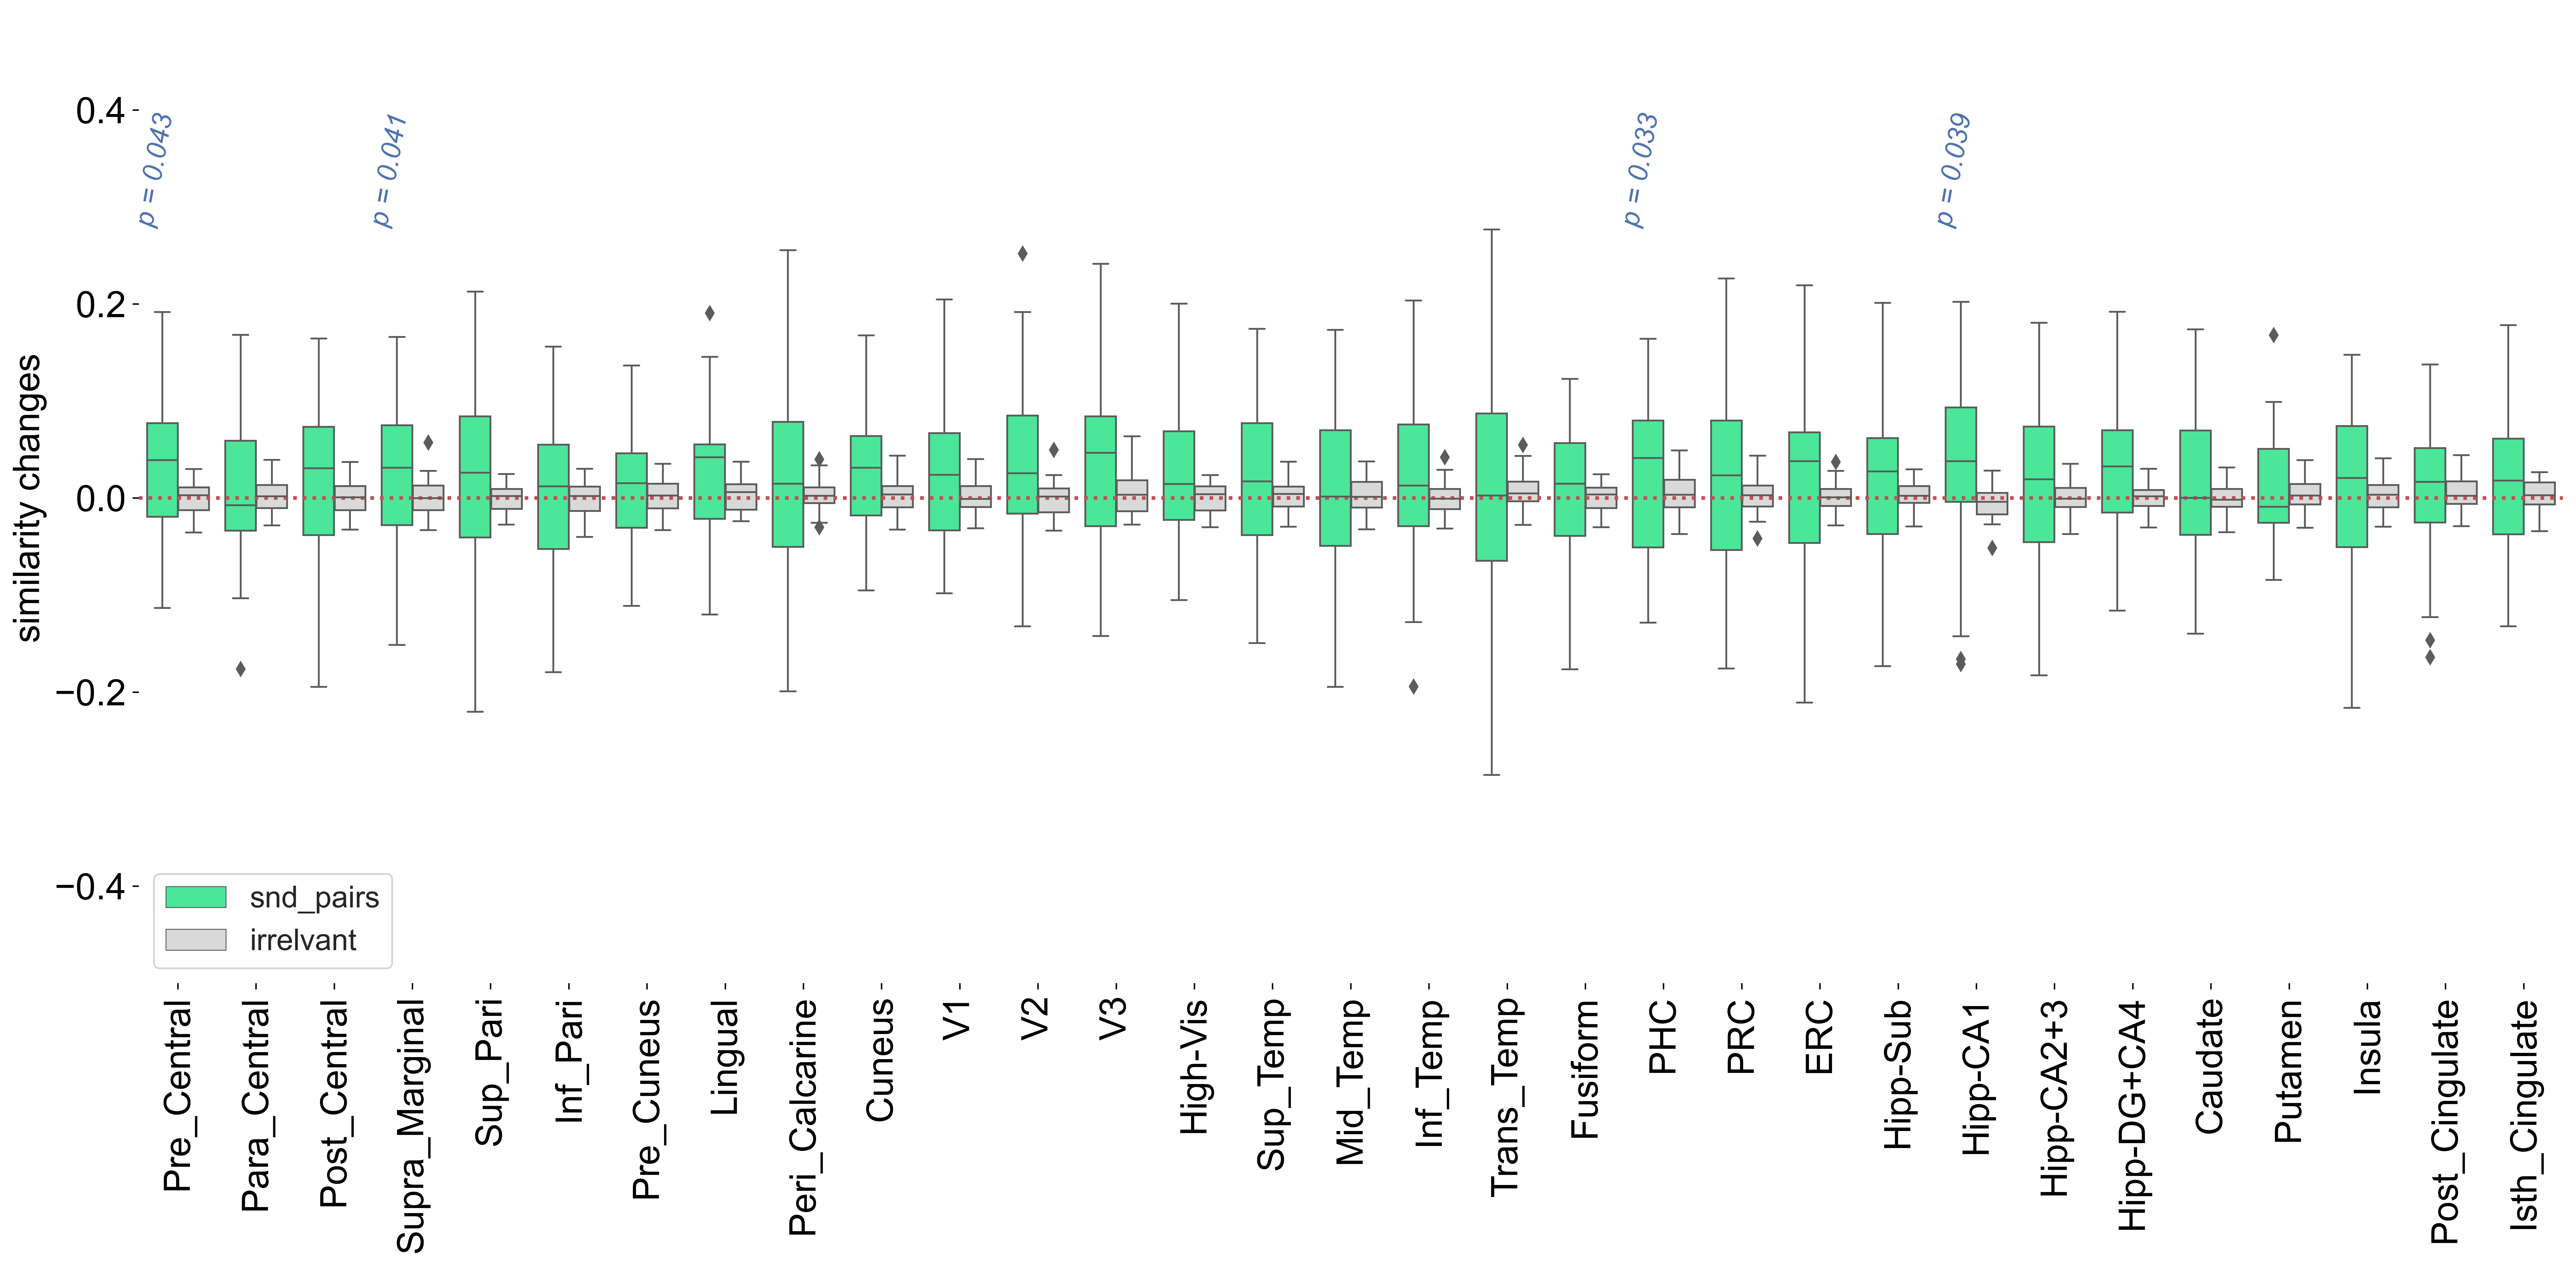

In [18]:
fig_name = "{:}.png".format(out_fn)

plot_my_compares(long_DF, selected_rois, tar_a, tar_b, 
                 DF_1s_a_pSig = DF_1s_a_pos.query("p_vals <= .05"), # DF_1stt.loc[DF_1stt["p_vals"] <= .05, :]
                 DF_1s_b_pSig = DF_1s_b_pos.query("p_vals <= .05"), 
                 DF_1s_a_nSig = DF_1s_a_neg.query("p_vals <= .05"), 
                 DF_1s_b_nSig = DF_1s_b_neg.query("p_vals <= .05"), 
                 DF_pwtt_sig  = DF_pwtt.query("p_vals <= .05"), 
                 ylim = [-.5, .5] if meas == 'correlation' else None,
                 fig_title = out_fn.replace("_", "  "), 
                 fp = os.path.join(out_dir, fig_name),  
                 fig_size=fig_size)